In [46]:
import os
import numpy as np
import pandas as pd

from itertools import product
from collections import defaultdict

import itertools

import mlflow
from mlflow import MlflowClient
from mlflow.entities import ViewType

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

import mpl_toolkits.axisartist as axisartist
# import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import matplotlib
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import StrMethodFormatter
import matplotlib.ticker as mtick
from matplotlib.colors import PowerNorm

from matplotlib.colors import ListedColormap

# %matplotlib widget
%matplotlib inline

os.environ['MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR'] = 'False'
matplotlib.rcParams['font.family'] = 'monospace'

In [47]:
!mkdir figures

mkdir: cannot create directory ‘figures’: File exists


In [48]:
class FirstElementHashable(tuple):
    def __eq__(self, comp):
        return self[0] == comp[0]

    def __ne__(self, comp):
        return self[0] != comp[0]

    def __hash__(self):
        return hash((self[0],))

class HashableDict(dict):
    def __eq__(self, comp):
        return self['id'] == comp['id']

    def __ne__(self, comp):
        return self['id'] != comp['id']

    def __hash__(self):
        return hash(self['id'])

def params_dict_to_string(d):
    st = list()
    for k, v in d.items():
        if isinstance(v, str):
            v = eval(v)
            st.append(f"{k}={v['name']}")
        elif isinstance(v, dict):
            st.append(f"{k}={v['name']}")
        else:
            if k[-1] == "_":
                k = k[:-1]
            v = str(v)#.replace('{', '(').replace('}', ')')
            st.append(f"{k}={v}")

    st = ' '.join(st)
    st = st.replace('_', '')
    return st


def title_from_dict(d):
    st = list()
    for k, v in d.items():
        # if k not in ya_keys:
        #     continue

        # if k[-1] == '_':
        #     k = k[:-1]

        if isinstance(v, str):
            v = eval(v)
            st.append(f"{k}={v['name']}")
        elif isinstance(v, dict):
            st.append(f"{k}={v['name']}")
        elif isinstance(v, set):
            # print(v)
            for i in v:
                if i is not None:
                    break
            # v = str(i).replace('{', '(').replace('}', ')')
            st.append(f"{k}={i}")
        else:
            st.append(f"{k}={str(v)}")

    st = ' '.join(st)
    st = st.replace('_', '')
    return st

In [49]:
tracking_uri = os.path.expanduser('~/mlruns/')
experiment_name = os.path.basename(os.getcwd())
# experiment_name = 'GPU'

In [50]:
colors=['red', 'blue', 'y', 'purple']
markers = ['>', 'o', 'd', 'D', '*']
linestyles = [
     ('solid',                 (0, ())),      # Same as (0, ())
     # ('loosely dotted',        (0, (1, 2))),
     ('dotted',                (0, (1, 1))),
     #('densely dotted',        (0, (1, 1))),
     #('long dash with offset', (5, (10, 3))),
     #('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (3, 3))),
     # ('densely dashed',        (0, (5, 1))),

     # ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (4, 2, 1, 2))),
     # ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (4, 4, 1, 4, 1, 4))),
     # ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

In [51]:
query = None
query = 'tags."about" = "full dataset" and params.model = "BERT"'
# query = 'tags."about" = "full dataset" and params.model = "ResNet18"'
# query = 'tags."about" = "rebuttal cutout aug"'

if query is None:
    raise ValueError('Uncomment one of the above lines to plot corresponding experiments')

label_keys = ['optimizer', 'eps']
same_plot = ['nepochs', 'seed']  # , 'mdlr_'
# ya_keys = ['beta1_, beta2_, eta_']
ya_keys = []

client = MlflowClient(tracking_uri=tracking_uri)
e = client.get_experiment_by_name(experiment_name)
runs = client.search_runs(experiment_ids=[e.experiment_id],
                          # filter_string=query,
                          filter_string=query,
                          run_view_type=ViewType.ACTIVE_ONLY)
configs = list()
ya_keys_set = set()  # contains parameters which can be None for some runs
id_lookup_set = set()
for r in runs:
    config = mlflow.artifacts.load_dict(r.info.artifact_uri+'/config.json', )
    configs.append(config)

    for k in config:
        v = config[k]
        if isinstance(v, dict):
            v = HashableDict(v)
            config[k] = v
            configs[-1][k] = v

        if k[-1] == '_' and k not in label_keys and k not in same_plot:
            ya_keys_set.add(k)

        d = dict()
        for k in label_keys: #  or k in same_plot:
            d.update({k: v})
        id_lookup_set.add(str(d))

id_lookup_list = list(id_lookup_set)
ya_keys += list(ya_keys_set)
ya_keys
params_set = set()
sparse_configs = list()

for i, r in enumerate(runs):
    config = configs[i]

    sparse_cfg = dict()
    for k, v in config.items():
        if k in label_keys or k in ya_keys or k in same_plot:
            continue
        sparse_cfg.update({k: v})
    params_set.add(str(sparse_cfg))
    sparse_configs.append(sparse_cfg)

params_set

{"{'loss': {'name': 'CrossEntropyLoss', 'id': 0}, 'model': {'name': 'BERT', 'id': 5}, 'dataset': {'name': 'GoEmotions', 'id': 0}, 'batchsize': 160, 'lr': 1e-05}"}

In [52]:
params_list = list(params_set)
ya_dicts_list = [set() for _ in params_set]
for i, r in enumerate(runs):
    config = configs[i]
    sparse_config = sparse_configs[i]
    i = params_list.index(str(sparse_config))

    d = dict()
    for k in ya_keys:
        if k not in same_plot:# and k not in label_keys:
            d.update({k: config[k]})
    ya_dicts_list[i].add(str(d))

In [53]:
# dicts = ya_dicts_list[0]

# d_out = defaultdict(set)
# for d in dicts:
#     for k, v in _eval(d).items():
#         if v is not None:
#             d_out[k].add(v)
    

In [54]:


# for i in product_dict(**d_out):
#     print(f"{i=}")

In [55]:
def product_dict(**kwargs):
    keys = kwargs.keys()
    for instance in itertools.product(*kwargs.values()):
        yield dict(zip(keys, instance))

        
def _eval(d):
    d = eval(d)
    for k in d.keys():
        if isinstance(v, str):
            d[k] = eval(d[k])
    return d

In [56]:
params_lists = list()
for p in params_set:
    d = _eval(p)
    params_lists.append([d.copy()])

runs_sets_lists = [[set()] for _ in params_lists]
for j, params_list in enumerate(params_lists):
    ya_dicts = [_eval(d) for d in sorted(ya_dicts_list[j])]

    ya_sparse = defaultdict(set)
    for d in ya_dicts:
        for k, v in d.items():
            if v is not None:
                ya_sparse[k].add(v)


    for d in product_dict(**ya_sparse):
        print(f"{d.values()=}")
        # if None in set(d.values()):
        #     continue
        d.update(params_list[0])
        params_list.append(d.copy())
        runs_sets_lists[j].append(set())
        print(f"{runs_sets_lists[j]=}")

print(f"{len(runs_sets_lists)=}")

d.values()=dict_values([0, 0.999, 0.9])
runs_sets_lists[j]=[set(), set()]
d.values()=dict_values([0.1, 0.999, 0.9])
runs_sets_lists[j]=[set(), set(), set()]
d.values()=dict_values([0.001, 0.999, 0.9])
runs_sets_lists[j]=[set(), set(), set(), set()]
len(runs_sets_lists)=1


In [57]:
def params_in_config(params, config, sparse=False):
    for k in params:
        if k not in ya_keys and config[k] != params[k]:
            return False

    for k in ya_keys:
        if config[k] is not None and ((k in params and config[k] != params[k]) or sparse):
            return False
    return True

sparse_extended = [False for _ in params_lists]
for i, r in enumerate(runs):
    config = configs[i]

    for j, params_list in enumerate(params_lists):
        for t, params in enumerate(params_list):
            if params_in_config(params_list[t], config, not t):
                runs_sets_lists[j][t].add(FirstElementHashable((r, config)))
                if t:
                    sparse_extended[j] = True

In [58]:
sparse_extended

[True]

In [59]:
labels = set()
for r in runs:
    labels.add(r.info.run_name)

lookup_id_dict = {v: i for i, v in enumerate(labels)}

def iterate_run_sets():
    for j, params_list in enumerate(params_lists):
        if sparse_extended[j] is False:
            yield params_list[0], runs_sets_lists[j][0]
        else:
            for i, params in enumerate(params_list):
                if i and len(runs_sets_lists[j][i]):
                    yield params, runs_sets_lists[j][i].copy().union(runs_sets_lists[j][0].copy())

In [60]:
from matplotlib import ticker

In [61]:
lookup_id_dict

{'AdaGrad': 0, 'KATE': 1, 'ADAM': 2}

In [62]:
lookup_id_dict = {'AdaGrad': 0, 'KATEADAM': 3, 'KATE': 1, 'ADAM': 2, 'TORCH AdaGrad': 4}

In [63]:
plt.rcParams["legend.handlelength"] = 5

params={'eta_': 0, 'beta2_': 0.999, 'beta1_': 0.9, 'loss': {'name': 'CrossEntropyLoss', 'id': 0}, 'model': {'name': 'BERT', 'id': 5}, 'dataset': {'name': 'GoEmotions', 'id': 0}, 'batchsize': 160, 'lr': 1e-05}

params={'eta_': 0.1, 'beta2_': 0.999, 'beta1_': 0.9, 'loss': {'name': 'CrossEntropyLoss', 'id': 0}, 'model': {'name': 'BERT', 'id': 5}, 'dataset': {'name': 'GoEmotions', 'id': 0}, 'batchsize': 160, 'lr': 1e-05}

params={'eta_': 0.001, 'beta2_': 0.999, 'beta1_': 0.9, 'loss': {'name': 'CrossEntropyLoss', 'id': 0}, 'model': {'name': 'BERT', 'id': 5}, 'dataset': {'name': 'GoEmotions', 'id': 0}, 'batchsize': 160, 'lr': 1e-05}



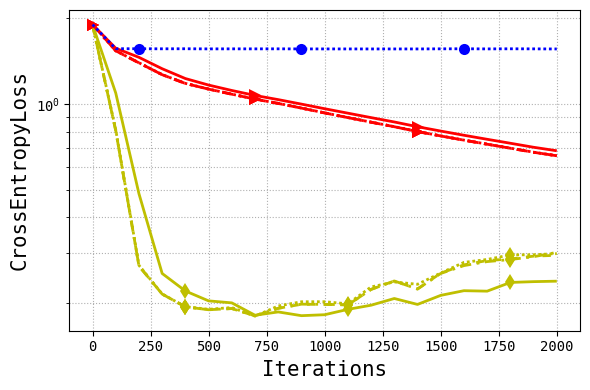

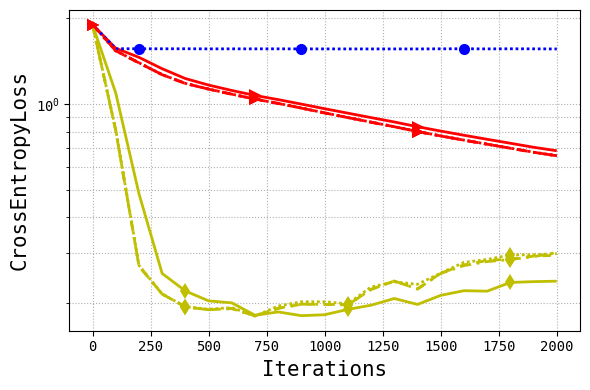

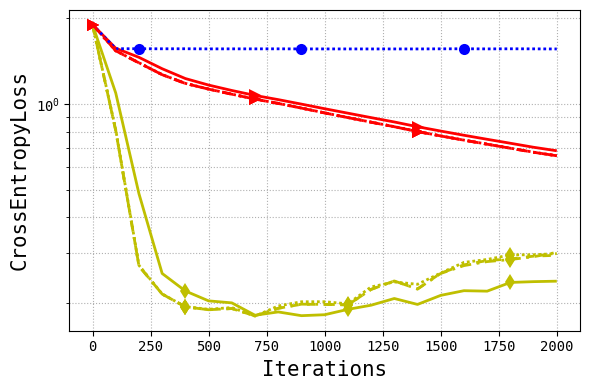

In [64]:
beg = 0
end = 20000
metric_key = 'train-loss'
metric_key = 'test-loss'
# metric_key = 'expected-loss'

for i, (params, runs) in enumerate(iterate_run_sets()):
    print(f"{params=}")
    print()
    if len(runs) < 3:
        continue

    title = params_dict_to_string(params)
    # fig, ax = plt.subplots(figsize=(8, 6))
    fig, ax = plt.subplots(figsize=(6, 4))
    # fig, ax = plt.subplots(figsize=(4, 3))
    for j, (r, config) in enumerate(runs):
        label = r.info.run_name
        
        if label=='KATE':
            if config['eps'] > 1e-6:
                continue
                
        # if label=='KATE':
        #     if config['eps'] in [1e-3, 1e-6]:
        #         continue

        id = lookup_id_dict[label]
        label = label + r' $\delta$=' + f"{config['eps']:.1e}"
        history = client.get_metric_history(run_id=r.info.run_id, key=metric_key)
        y = np.array([h.value for h in history])
        # x = np.array([h.timestamp for h in history])
        x = np.array([h.step for h in history])
        mask = (x >= beg)*(x <= end)
        x, y = x[mask], y[mask]
        
        
        
        if config['eps'] == 1e-4:
            ls=0
        elif config['eps'] == 1e-6:
            ls=1
        elif config['eps'] == 1e-8 or config['eps'] == 1e-3:
            ls=2
        elif config['eps'] == 1e-10 or config['eps'] == 1e-5:
            ls=3
        # print(f"{config['eps']=}")
        # print(f"{type(config['eps'])=}")
        j = id
        # j = ls
        ax.plot(x, y,
                alpha=1,
                color=colors[id],
                marker=markers[id],
                markevery=slice(2*j, len(x), 7), markersize=8,
                label=label, linewidth=2,
                markeredgecolor='white', markeredgewidth=0, linestyle=linestyles[ls][1])

    # ax.set_title(metric_key + ' ' + title, fontsize=7)
    ax.set_yscale('log')
    ax.grid(True, which="both", ls='dotted')
    loc = ax.yaxis.get_minor_locator()
    handles, labels = ax.get_legend_handles_labels()
    # [ha.set_linelength(7) for ha in handles ]
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=False))
    # ax.legend(handles, labels, loc='upper left')
    # ax.legend(loc='center right')


    ax.set_xlabel('Iterations', fontsize=15)
    # ax.set_xscale('log')

    ax.set_ylabel(params['loss']['name'], fontsize=15)

    locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
    locmin = matplotlib.ticker.LogLocator(base=10.0, subs=[i/10 for i in range(0,10)], numticks=100)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    # ax.yaxis.set_minor_locator(ticker.NullLocator())
    # ax.tick_params(axis='x', which='major', bottom=False)
    # ax.set_ylabel(r'Accuracy')
    # ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) # 2 decimal places
    # ax.yaxis.set_minor_formatter(mtick.FormatStrFormatter('%.0e')) # 2 decimal places

    # formatter = mtick.ScalarFormatter()
    # formatter.set_scientific(True)
    # ax.yaxis.set_minor_formatter(formatter)
    # ax.yaxis.set_major_formatter(formatter)
    # ax.ticklabel_format(axis="y", style="sci", scilimits=(.1,.1))

    name = metric_key + ' ' + title
    plt.savefig('figures/'+ name +'.pdf', bbox_inches='tight')
    plt.tight_layout()
    fig.show()
    # break

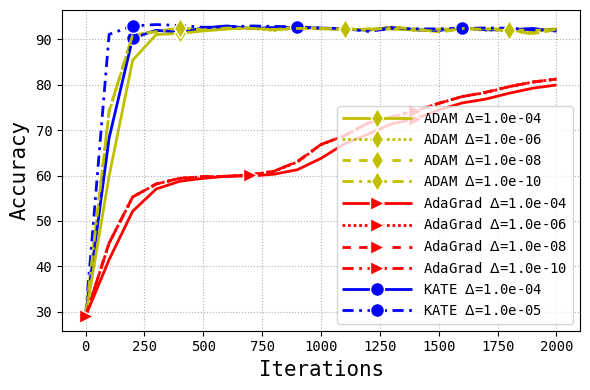

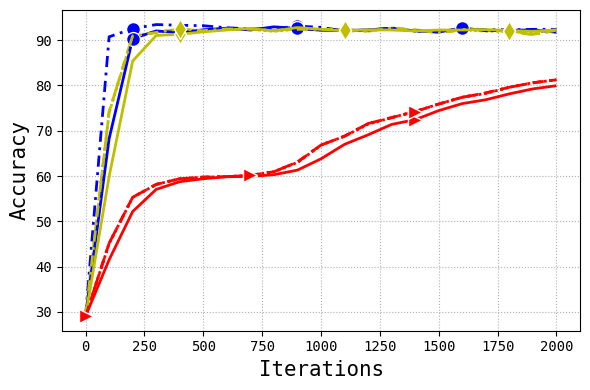

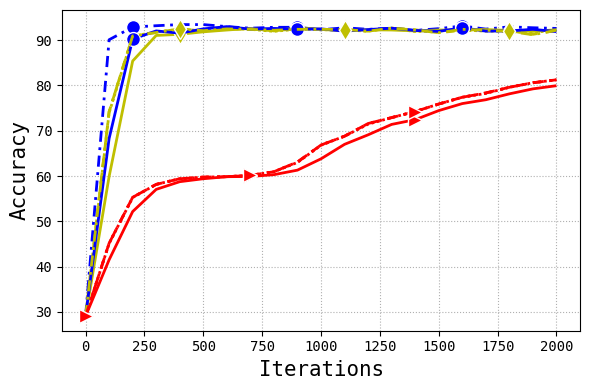

In [65]:
### beg = 500
beg = 0
end = 20000
metric_key = 'test-accuracy'
# metric_key = 'train-accuracy'
for i, (params, runs) in enumerate(iterate_run_sets()):
    if len(runs) < 3:
        continue
    # print(f"{params=}")
    # print(f"{i=}")
    # print()

    title = params_dict_to_string(params)
    # fig, ax = plt.subplots(figsize=(8, 6))
    fig, ax = plt.subplots(figsize=(6, 4))
    for j, (r, config) in enumerate(runs):
        label = r.info.run_name
        # if label=='KATE':
        #     if config['eps'] > 1e-6:
        #         continue
                
        if label=='KATE':
            if config['eps'] in [1e-3, 1e-6]:
                pass
                continue
                
        id = lookup_id_dict[label]
        label = label + r' $\Delta$=' + f"{config['eps']:.1e}"
        history = client.get_metric_history(run_id=r.info.run_id, key=metric_key)
        y = np.array([h.value for h in history])
        # x = np.array([h.timestamp for h in history])
        x = np.array([h.step for h in history])
        mask = (x >= beg)*(x <= end)
        x, y = x[mask], y[mask]
        if config['eps'] == 1e-4:
            ls=0
        elif config['eps'] == 1e-6:
            ls=1
        elif config['eps'] == 1e-8 or config['eps'] == 1e-3:
            ls=2
        elif config['eps'] == 1e-10 or config['eps'] == 1e-5:
            ls=3
        j = id
        ax.plot(x, y,
                alpha=1,
                color=colors[id],
                marker=markers[id],
                markevery=slice(2*j, len(x), 7), markersize=10,
                label=label, linewidth=2,
                markeredgecolor='white', markeredgewidth=1, linestyle=linestyles[ls][1])

    # ax.set_title(metric_key + ' ' + title, fontsize=7)
    ax.grid(True, which="both", ls='dotted')
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0], reverse=False))
    if params['eta_'] == 0:
        ax.legend(handles, labels, loc='lower right')
    # ax.legend(handles, labels, loc='lower right')
    # ax.legend(loc='center right')

    ax.set_xlabel('Iterations', fontsize=15)
    # ax.set_xscale('log')

    ax.set_ylabel('Accuracy', fontsize=15)
    # ax.set_yscale('log')
    # ax.set_ylabel(r'Accuracy')
    # plt.gca().invert_yaxis()
    # ax.set_ylim(bottom=0.6)#, top=1)#, *, emit=True, auto=False, ymin=None, ymax=None)
    # ax.set_ylim(bottom=None, top=None, *, emit=True, auto=False, ymin=None, ymax=None)
    # ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e')) # 2 decimal places
    # ax.yaxis.set_minor_formatter(mtick.FormatStrFormatter('%.2e')) # 2 decimal places
    # formatter = mtick.ScalarFormatter()
    # formatter.set_scientific(True)
    # ax.yaxis.set_minor_formatter(formatter)
    # ax.yaxis.set_major_formatter(formatter)
    # ax.ticklabel_format(axis="y", style="sci", scilimits=(1e-2,1e-2))

    name = metric_key + ' ' + title
    plt.savefig('figures/'+ name +'.pdf', bbox_inches='tight')
    plt.tight_layout()
    fig.show()